# Librairies

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import os
import json
import re 
import itertools
import umap.umap_ as umap
import hdbscan
import pubchempy

# RDkit
from rdkit import Chem

# Plotting
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

# Functions

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def get_family(x):
    res = re.search(r'^OR([0-9]+)[A-Z]+[0-9]+$',x)[1]
    return res

def compute_smiles(cids_list, batch_size, properties='smiles'):
    def batch(iterable, n=1):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]
    
    _smiles = []
    for x in batch(range(0, len(cids_list)), batch_size):
        batch_cid = [cids_list[i] for i in x]
        if properties == 'smiles':
            batch_smiles = [i.isomeric_smiles for i in pubchempy.get_compounds(batch_cid, namespace='inchikey')]
        elif properties == 'inchikey':
            batch_smiles = [i.inchikey for i in pubchempy.get_compounds(batch_cid)]
        _smiles.append(batch_smiles)
    
    return list(itertools.chain(*_smiles))

def _change_units(x, _from, _to):
    try:
        x = float(x)
    except:
        return x
    if _from == 'uM' and _to == 'Log(M)':
        return np.log10(x) - 6.0 # uM = 10^-6 M
    elif _from == 'Log(M)' and _to == 'uM':
        return 10.0**(x + 6.0)
    elif _from == 'mM' and _to == 'uM':
        return x*(10.0**3)

def _func_data_ec50(data_ec50):
    pairs_ec50 = data_ec50.groupby(['_MolID', 'mutated_Sequence']).apply(lambda x: x['Responsive'].mean()) # TODO: apply more complex function returning {'Responsive', 'sample_weight'}
    if ((pairs_ec50 > 0.0)&(pairs_ec50 < 1.0)).any():
        _ec50_inconsitent_idx = pairs_ec50[((pairs_ec50 > 0.0)&(pairs_ec50 < 1.0))].index
        print('INFO: To discard EC50 inconsistent: {}'.format(len(_ec50_inconsitent_idx)))
        pairs_ec50 = pairs_ec50.loc[pairs_ec50.index.difference(_ec50_inconsitent_idx)]
    pairs_ec50 = pairs_ec50.astype(int)
    pairs_ec50.name = 'Responsive'
    pairs_ec50 = pairs_ec50.to_frame()
    pairs_ec50['_DataQuality'] = 'ec50'
    return pairs_ec50

def _func_data_screening(data_screening):
    """
    """
    def num_unique_value_screen(_df):
        return len(_df['Value_Screen'].unique())

    def _is_sorted(s):
        return all(s.iloc[i] <= s.iloc[i+1] for i in range(len(s) - 1))
        
    _screening_consistency_ordering = data_screening.groupby(['_MolID', 'mutated_Sequence']).apply(lambda x: _is_sorted(x.sort_values(['Value_Screen', 'Responsive'])['Responsive']))
    _screening_consistency_ordering.name = 'Check'
    _screening_inconsistent_ordering_idx = _screening_consistency_ordering[~_screening_consistency_ordering].index
    _screening_consistent_ordering_idx = _screening_consistency_ordering[_screening_consistency_ordering].index
    print('INFO: To discard because of screening ordering (Inconsistent through Value_Screen): {}'.format(len(_screening_inconsistent_ordering_idx)))

    _screening_consistency_per_value = data_screening.groupby(['_MolID', 'mutated_Sequence', 'Value_Screen']).apply(lambda x: ((x['Responsive']==1).all() or (x['Responsive']==0).all()))
    _screening_consistency_per_value.name = 'Check'
    _screening_consistency_per_value = _screening_consistency_per_value.reset_index('Value_Screen')
    _screening_inconsitent_per_value_idx = _screening_consistency_per_value[~_screening_consistency_per_value['Check']].index
    _screening_inconsitent_per_value_idx = _screening_inconsitent_per_value_idx.drop_duplicates()
    _screening_consitent_per_value_idx = _screening_consistency_per_value[_screening_consistency_per_value['Check']].index
    _screening_consitent_per_value_idx = _screening_consitent_per_value_idx.drop_duplicates()
    print('INFO: To discard screening inconsistent per Value_Screen: {}'.format(len(_screening_inconsitent_per_value_idx)))

    _screening_inconsitent_idx = _screening_inconsitent_per_value_idx.union(_screening_inconsistent_ordering_idx)
    print('INFO: To discard screening inconsistent: {}'.format(len(_screening_inconsitent_idx)))

    pairs_screening = data_screening.groupby(['_MolID', 'mutated_Sequence']).apply(lambda x: (x['Responsive']==1).any()).astype(int) # TODO: apply more complex function returning {'Responsive', 'sample_weight'}
    pairs_screening.name = 'Responsive'
    pairs_screening = pairs_screening.to_frame()
    pairs_screening = pairs_screening.loc[pairs_screening.index.difference(_screening_inconsitent_idx)] # TODO: Discarding inconsistent here. Do we want to do it?

    _count_unique_concentrations = data_screening.groupby(['_MolID', 'mutated_Sequence']).apply(num_unique_value_screen)
    _count_unique_concentrations.name = 'num_unique_value_screen'

    pairs_screening = pairs_screening.join(_count_unique_concentrations, how='left')        

    pairs_primary = pairs_screening[pairs_screening['num_unique_value_screen'] == 1].copy()
    pairs_primary['_DataQuality'] = 'primaryScreening'
    pairs_secondary = pairs_screening[pairs_screening['num_unique_value_screen'] > 1].copy()
    pairs_secondary['_DataQuality'] = 'secondaryScreening'

    return pairs_primary, pairs_secondary

def choose_smiles(x):
    """
    This is consistent with prepro.py
    """
    if x['GS_SMILES'] == x['GS_SMILES']:
        return x['GS_SMILES']
    else:
        return x['paper_SMILES']

def broadness_measure(x):
    n = x.shape[0]
    x_bool = x > 0.5
    # return x_bool
    return sum(x_bool).astype(np.float32) / n

def get_map_CID_to_inchikey(cid):
    mols = pubchempy.get_compounds(cid, 'cid')
    return {mol.cid: mol.inchikey for mol in mols if mol is not None}

def _unique_atomic_num(smiles):
    mol = Chem.MolFromSmiles(smiles.strip())
    X = []
    for atom in mol.GetAtoms():
        X.append(atom.GetAtomicNum())
    x = np.array(X, dtype = int)
    return np.unique(x)
    
def _test_CNOS_atomic_num(smiles):
    mol = Chem.MolFromSmiles(smiles.strip())
    X = []
    for atom in mol.GetAtoms():
        X.append(atom.GetAtomicNum())
    x = np.array(X, dtype = int)
    for ele in np.unique(x):
        if ele not in [6, 7, 8, 16]:
            return False
    return True

def _get_most_occuring_pyrfume_descriptor(df, i = 0, return_stats = False, top_k = 1):
    s = df['pyrfume_odor'].str.split(',').explode()
    _count = s.groupby(s).count().sort_values(ascending = False)
    if return_stats:
        return _count.index[i], _count.iloc[i], _count.iloc[i]/len(df)
    else:
        return '_'.join(_count.index[i:i+top_k].to_list())

def get_quantile_per_odor_group(df, q = 0.75):
    if len(df) > 9:
        _X = np.stack(df['predict'])
        _X = (_X > 0.5).astype(float)
        _dist = pairwise_distances(_X, metric = 'l1')
        try:
            _dist_triu = _dist[np.triu_indices(n = _dist.shape[0], k = 1)] # /(len(df) - 1)
            median_distances = np.median(_dist, axis=1)
            # nanmedian_distances = np.nanmedian(_dist, axis=1)
            # nanmedian_distances = np.sum(nanmedian_distances, axis=1) / (len(nanmedian_distances) - 1)  
            return np.quantile(median_distances, q = q)
        except Exception as e:
            print(df['predict'])
            raise e
    else:
        return float('nan')

def perform_mutation(row, mutation_col = 'Mutation', seq_col = 'Sequence'):
    """
    Perform mutation on a row in pandas.DataFrame. This function is designed to be used in pandas apply.

    Paramters:
    ----------
    row : pandas.Series
        row of pandas dataframe

    mutation_col : str
        name of the column with mutation information.

    seq_col : str
        name of the column with sequences.

    Returns:
    --------
    mutated_seq : str
        mutated sequence
    """
    try:
        if row[mutation_col] == row[mutation_col] and row[seq_col] == row[seq_col]:
            seq = row[seq_col]
            mutations = row[mutation_col].strip().split('_')
            return _perform_mutation(mutations, seq)
        else:
            return row[seq_col]
    except Exception as e:
        print(row)
        print(row[seq_col])
        raise  e

def _perform_mutation(mutations, seq):
    """
    Main logic for performing mutations.
    """    
    for mutation in mutations:
        # print('->' + mutation)
        _from = mutation[0]
        _to = mutation[-1]
        _position = int(mutation[1:-1]) - 1
        if seq[_position] == _from:
            seq = seq[:_position] + _to + seq[_position+1:]
        else:
            left_pos = _position - 5
            right_pos = _position + 4
            if _position < 5: left_pos = 0
            if _position > len(seq) - 4: right_pos = len(seq)
            raise 'Expected letter {} on position {} in sequence arround: {}. Found {}. Mutation: {}'.format(_from, _position, seq[left_pos:right_pos], seq[_position], mutation)
    return seq

def get_quantile_per_code_group(df, q = 0.75):
    if len(df) > 15:
        _X = np.stack(df['embed'])
        _dist = pairwise_distances(_X, metric = 'l2')
        try:
            _dist_triu = _dist[np.triu_indices(n = _dist.shape[0], k = 1)] # /(len(df) - 1)
            return np.quantile(_dist_triu, q = q)
        except Exception as e:
            print(df['embed'])
            raise e
    else:
        return float('nan')

def merge_cols_with_priority(row, primary_col = 'Uniprot_Sequence', secondary_col = 'Sequence'): # merge_seqs
    """
    merge two columns. primary column is kept and only if entry is missing use secondary_col.
    This should be used in pandas apply.

    Paramters:
    ----------
    row : pandas.Series
        row of pandas dataframe.
    
    primary_col : str
        name of the main column.

    secondary_col : str
        name of the secondary column used only when info in the first is missing.

    Returns:
    --------
    entry : Any
        value to put to the merged column.
    """
    if row[primary_col] == row[primary_col]:
        return row[primary_col]
    else:
        return row[secondary_col]

### Combinatorial code plot functions:

In [3]:
# --- Molecules ----------------------------------------------
def get_ordered_mols(df, _mols_order_by, _df_predict_unstack, discard_unclustered = True):
    """
    Molecules can be odred by:
        - embedding_cluster_hdbscan - by abstract odor families ids
        - embedding_cluster_top_descriptor - by top occuring descriptors in the abstract odor families
        - code_cluster_hdbscan - by clustering in the combinatorial coding.
        - broadness - by broadness of moleucles
    """
    _mols = df.loc[_df_predict_unstack.index.intersection(df.index)].copy() # Double check
    _mols = _mols.dropna(subset = [_mols_order_by])
    # _mols = _mols.sort_values([_mols_order_by])
    if _mols_order_by in ['embedding_cluster_hdbscan', 'embedding_cluster_top_descriptor']:
        if discard_unclustered:
            _mols = _mols[_mols['embedding_cluster_hdbscan'] >= 0]
        if _mols_order_by == 'embedding_cluster_top_descriptor':
            _mols['embedding_cluster_top_descriptor'] = _mols.apply(lambda x: str(x['embedding_cluster_top_descriptor']) + '_' + str(x['embedding_cluster_hdbscan']) , axis = 1)
        _mols[_mols_order_by] = _mols[_mols_order_by].astype(str)
    if _mols_order_by in ['code_cluster_hdbscan']:
        if discard_unclustered:
            _mols = _mols[_mols['code_cluster_hdbscan'] >= 0]
        _mols[_mols_order_by] = _mols[_mols_order_by].astype(str)
        
    _mols = _mols.sort_values([_mols_order_by, 'broadness'])
    _mols = _mols[_mols_order_by]
    return _mols

# --- Receptors ----------------------------------------------
def get_ordered_genes(df, _gene_order_by):
    """
    ORs can be odred by:
        - family_broadness - by family name and by broadness inside the families
        - family - by family name.
        - broadness - by broadness of moleucles
    """
    if _gene_order_by == 'broadness':
        _gene = df.copy()
        _gene = _gene.sort_values('broadness')
    elif _gene_order_by == 'family':
        _gene = df.copy()
        _gene['family'] = _gene.index.str.extract(pat = r'(\d+)').values 
        _gene = _gene.sort_values(_gene_order_by)
    elif _gene_order_by == 'family_broadness':
        _gene = df.copy()
        _gene['family'] = _gene.index.str.extract(pat = r'(\d+)').values 
        _gene = _gene.sort_values(['family', 'broadness'])  
    return _gene

In [4]:
def plot_combinatorial_code(_mols_order_by, _gene_order_by, 
                            df_predict_unstack, df_mols_joint, 
                            df_OR, odor_print_treshold = 10, 
                            transpose = True, cmap = None, 
                            discard_unclustered = True, ticks_broadness_threshold = None):
    """
    Parameters:
    -----------
        _mols_order_by : str
            moleceule ordering

        _gene_order_by : str
            OR ordering
            
        df_predict_unstack : pandas.DataFrame
            unstacked dataframe with predictions

        df_mols_joint : pandas.DataFrame
            dataframe with all the informations about moleucles

        df_OR : pandas.DataFrame
            dataframe with all the informations about ORs

        odor_print_treshold : int
            tick names of groups with less than odor_print_treshold molecule are not printed

        transpose : bool
            whether to transpose the matrix

        cmap : object
            matplotlib cmap to use in matshow

        discard_unclustered : bool
            whether to discard unclustered group from hdbscan (i.e. label -1)

        ticks_broadness_threshold : float
            tick names of ORs with lower broadness than ticks_broadness_threshold are not printed
    """
    _mols = get_ordered_mols(df_mols_joint, _mols_order_by, df_predict_unstack, discard_unclustered = discard_unclustered)
    _gene = get_ordered_genes(df_OR, _gene_order_by)
    _gene_idx = _gene.index
    # --- Plot ----------------------------------------------
    def _tmp_func(x, _discard_idx):
        if x in _discard_idx:
            return ''
        else:
            return x

    _pred = df_predict_unstack.loc[_mols.index][_gene_idx]
    # _pred = _pred >= 0.5

    # Create mols ticks:
    _tmp = _mols.reset_index().groupby(by = _mols_order_by, sort = True).count()['InchiKey']
    _tmp.name = 'tick_position'
    _mols_ticks = _tmp.cumsum() - 1
    _mols_ticks = _mols_ticks.reset_index()
    _discard_idx = _tmp[_tmp < odor_print_treshold].index
    _mols_ticks['tick_name'] = _mols_ticks[_mols_order_by].apply(lambda x: _tmp_func(x, _discard_idx))
    del _tmp, _discard_idx

    # Create gene ticks:
    _gene_ticks = pd.DataFrame({'tick_position' : range(len(_gene_idx)), 'tick_name' : _gene_idx.to_list()})
    if ticks_broadness_threshold is not None:
        _discard_idx = _pred.columns[_pred.mean() <= ticks_broadness_threshold]
        _gene_ticks['tick_name'] = _gene_ticks['tick_name'].apply(lambda x: _tmp_func(x, _discard_idx))
        del _discard_idx

    fig = plt.figure(dpi = 300, figsize = [10, 4])
    ax = fig.add_subplot(111)

    if transpose:
        cax = ax.matshow(_pred.T.values, cmap = cmap)
        ax.set_xticks(list(_mols_ticks['tick_position']), list(_mols_ticks['tick_name']), rotation='vertical', fontsize = 2) # fontsize = 3
        ax.set_yticks(list(_gene_ticks['tick_position']), list(_gene_ticks['tick_name']), fontsize = 2)
        # ax.set_yticks([],[])
    else:
        cax = ax.matshow(_pred.values, cmap = cmap)
        ax.set_yticks(list(_mols_ticks['tick_position']), list(_mols_ticks['tick_name']), fontsize = 2) # fontsize = 3
        ax.set_xticks(list(_gene_ticks['tick_position']), list(_gene_ticks['tick_name']), rotation='vertical', fontsize = 2)
        # ax.set_yticks([],[])
    ax.xaxis.set_tick_params(width=0.1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return fig, ax, cax

# Raw Data

## Paths:

In [5]:
working_dir = '<path_to_directory>/Receptor2Odorant'

In [6]:
Dataset_path = os.path.join(working_dir, 'RawData/m2or/export_20220512-135815.csv')
model_predictions_path = os.path.join(working_dir, 'Figures/Data/predict_Model20220613-091215_e10000.csv')

# Auxiliary files:
uniprot_sequences_path = os.path.join(working_dir, 'RawData/m2or/uniprot_sequences.csv')
seq_df_path = os.path.join(working_dir, 'Figures/Data/seqs.csv')
mol_df_path = os.path.join(working_dir, 'Figures/Data/mols.csv')
ncbi_table_path = os.path.join(working_dir, 'Figures/Data/table_ncbi_identifier_name_sequence_stripped.json')
goodscents_path = os.path.join(working_dir, 'Figures/Data/merged_GoodScent_merged_paper_SMILES_to_Smell.csv')
pyrfume_path = os.path.join(working_dir, 'Figures/Data/full_data.csv')
odor_embedding_json = os.path.join(working_dir, 'Figures/Data/pyrfume_embedding_2022_09_08_embed.json')
odor_embedding_source = os.path.join(working_dir, 'Figures/Data/pyrfume_embedding_2022_09_08_source.csv')
map_CID_to_inchikey_path = os.path.join(working_dir, 'Figures/Data/map_CID_to_inchikey.json')
classes_mapping_path = os.path.join(working_dir, 'Figures/Data/classes_mapping.json')
map_inchikey_to_isomericSMILES = os.path.join(working_dir, 'Figures/Data/map_inchikey_to_isomericSMILES.json')


## Load data:

In [7]:
df_full = pd.read_csv(Dataset_path, sep=';')
df = pd.read_csv(model_predictions_path, sep=';')

# Auxiliary files:
df_uniprot = pd.read_csv(uniprot_sequences_path, sep = ';', index_col = None)
seq_input_df = pd.read_csv(seq_df_path, sep=';', index_col = None)
mol_input_df = pd.read_csv(mol_df_path, sep=';', index_col = None)
seq_df_raw = pd.read_json(ncbi_table_path, orient='index')
df_odor = pd.read_csv(goodscents_path, sep=';')
df_pyrfume = pd.read_csv(pyrfume_path, sep=';', index_col = 0)
df_odor_embedding_json = pd.read_json(odor_embedding_json, orient = 'index').set_index('_SMILES')
df_odor_embedding_index = pd.read_csv(odor_embedding_source, sep=';', index_col=0)
with open(map_CID_to_inchikey_path, 'r') as jsonfile:
    pyrfume_map_cid_to_inchikey = json.load(jsonfile)
with open(classes_mapping_path, 'r') as jsonfile:
    pyrfume_classes_mapping = json.load(jsonfile)
    pyrfume_classes_mapping = {val: key for key, val in pyrfume_classes_mapping.items()}
with open(map_inchikey_to_isomericSMILES, 'r') as jsonfile:
    map_inchikey_to_isomericSMILES = json.load(jsonfile)

/tmp/ipykernel_664/2275159523.py:1: DtypeWarning: Columns (2,5,10,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv(Dataset_path, sep=';')


## Prepare the data:

In [8]:
df_full = df_full[df_full.Mixture != 'mixture']
df_uniprot.set_index('Entry', drop = True, inplace = True)
df_full = df_full.join(df_uniprot[['Uniprot_Sequence']], on = 'Uniprot ID', how = 'left')
df_full['_MolID'] = df_full.apply(lambda x: merge_cols_with_priority(x, primary_col = 'InChI Key', secondary_col = 'canonicalSMILES'), axis = 1)
df_full['_Sequence'] = df_full.apply(lambda x: merge_cols_with_priority(x, primary_col = 'Uniprot_Sequence', secondary_col = 'Sequence'), axis = 1)
df_full['mutated_Sequence'] = df_full.apply(lambda x: perform_mutation(x, mutation_col = 'Mutation', seq_col = '_Sequence'), axis = 1)
# Change units
df_full.loc[df_full['Unit'] == 'uM', 'Value'] = df_full[df_full['Unit'] == 'uM']['Value'].apply(lambda x: _change_units(x, _from = 'uM', _to = 'Log(M)'))
df_full.loc[df_full['Unit'] == 'uM', 'Unit'] = 'Log(M)'
df_full.loc[df_full['Unit_Screen'] == 'mM', 'Value_Screen'] = df_full[df_full['Unit_Screen'] == 'mM']['Value_Screen'].apply(lambda x: _change_units(x, _from = 'mM', _to = 'uM'))
df_full.loc[df_full['Unit_Screen'] == 'mM', 'Unit_Screen'] = 'uM'
# process EC50
data_ec50 = df_full[df_full['Parameter'] == 'ec50']
pairs_ec50 =_func_data_ec50(data_ec50)
# process Screening
data_screening = df_full[df_full['Parameter'] != 'ec50']
if not data_screening.empty:
        pairs_primary, pairs_secondary = _func_data_screening(data_screening)
        pairs_primary = pairs_primary.loc[pairs_primary.index.difference(pairs_ec50.index)] 
        pairs_secondary = pairs_secondary.loc[pairs_secondary.index.difference(pairs_ec50.index)]

        pairs = pd.concat([pairs_ec50, pairs_primary, pairs_secondary])
else:
    pairs = pairs_ec50
pairs['Responsive'] = pairs['Responsive'].astype(int)

# Merge sequence and molecule information.
_tmp_seq = pd.merge(seq_input_df, seq_df_raw, left_on = 'mutated_Sequence', right_on = 'Sequence')
_tmp_seq = _tmp_seq[['seq_id', 'Accesion_Number','Gene','Sequence']]
_tmp_pred = pd.merge(df, mol_input_df, on = '_SMILES')
df_predict = pd.merge(_tmp_pred, _tmp_seq, on='seq_id')
df_predict.set_index(['seq_id', 'mol_id'], drop=True, inplace = True)
df_predict.rename(columns = {'pred':'predict', '_MolID' : 'InchiKey'}, inplace = True)

df_predict_unstack = df_predict.copy()
df_predict_unstack.set_index(['Gene', 'InchiKey'], drop = True, inplace = True)
df_predict_unstack = df_predict_unstack['predict'].unstack(level = 0)

df_odor['SMILES'] = df_odor.apply(choose_smiles, axis=1)
df_odor.set_index('InchiKey', inplace = True)

# odor embedding:
df_odor_embedding = df_odor_embedding_index.join(df_odor_embedding_json, on = '_SMILES', how='inner')
df_odor_embedding.rename(columns = {'prediction' : 'odorModel_label', 'InChI Key' : 'InchiKey', '_SMILES' :'SMILES'}, inplace = True)
df_odor_embedding.drop(columns = ['_MolID', 'canonicalSMILES'], inplace = True)
df_odor_embedding.set_index('InchiKey', inplace = True)

# Map one-hot to labels:
df_pyrfume['pyrfume_odor'] = df_pyrfume['Values'].apply(lambda x: ','.join([pyrfume_classes_mapping[key] for key in list(np.where(np.array(x[1:-1].split(', '), dtype=int) == 1)[0])]))
df_pyrfume['InchiKey'] = df_pyrfume['CID'].astype(int).astype(str).map(pyrfume_map_cid_to_inchikey)

# Add GoodScent descriptors: 
df_odor = df_pyrfume.join(df_odor, on = 'InchiKey', how = 'left', rsuffix = '_GS')

# Mols view:
df_mols = df_predict_unstack.apply(lambda x: np.array(x), axis = 1)
df_mols.name = 'predict'
df_mols = df_mols.to_frame()
df_mols['SMILES'] = df_mols.index.map(map_inchikey_to_isomericSMILES)
df_mols['broadness'] = df_mols['predict'].apply(broadness_measure)

# OR view
df_OR = df_predict.groupby('Gene').apply(lambda x: np.array(x['predict']))
df_OR.name = 'predict'
df_OR = df_OR.to_frame()
df_OR['broadness'] = df_OR['predict'].apply(broadness_measure)


_tmp = df_mols[df_mols['broadness'] <= 10e-7].copy()
_tmp['max_predict'] = _tmp['predict'].apply(lambda x: np.max(x))
# Save non active SMILES
non_active_mols_idx = _tmp.index
del _tmp


df_mols_active = df_mols.loc[df_mols.index.difference(non_active_mols_idx)].copy()
df_mols_non_active = df_mols.loc[non_active_mols_idx].copy()

df_mols = df_mols_active.copy()
df_mols = df_mols[df_mols['SMILES'].apply(_test_CNOS_atomic_num)].copy()
df_odor = df_odor[~(df_odor['pyrfume_odor'].str.contains('odorless'))].copy()

# Generate clustering based on odor predcition embedding:
_data = np.stack(df_odor_embedding['embed'], axis = 0)
uamp_embedding = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=5, random_state=345).fit_transform(_data) # 15, 0
labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10).fit_predict(uamp_embedding) # 15 , 12 # 10, 10
df_odor_embedding['uamp_embedding'] = list(uamp_embedding)
df_odor_embedding['embedding_cluster_hdbscan'] = labels.astype(int)

# Generate clustering based on combinatorial code:
df_code = df_mols.copy()
_data = np.stack(df_code['predict'], axis = 0)
uamp_embedding = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=5, random_state=345).fit_transform(_data) # 15, 0
labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=10, metric = 'manhattan').fit_predict(uamp_embedding) # 15 , 12 # 10, 10
df_code['code_uamp_embedding'] = list(uamp_embedding)
df_code['code_cluster_hdbscan'] = labels.astype(int)
labels = AgglomerativeClustering(n_clusters = 100).fit_predict(_data)
df_code['code_cluster_aglo'] = labels.astype(int)

df_mols_joint = df_mols.copy()
df_mols_joint = df_mols_joint.join(df_odor_embedding[['embedding_cluster_hdbscan', 'odorModel_label', 'embed', 'uamp_embedding']], on = 'InchiKey', how='inner')
df_mols_joint = pd.merge(df_mols_joint, df_odor[['pyrfume_odor', 'GS_Odor type', 'merged_odors', 'InchiKey']], on = 'InchiKey', how='inner')
df_mols_joint = df_mols_joint.join(df_code[['code_cluster_hdbscan', 'code_uamp_embedding', 'code_cluster_aglo']], on = 'InchiKey', how='inner')
df_mols_joint.set_index('InchiKey', inplace = True)

embedding_cluster_top_descriptor_mapping = df_mols_joint.groupby('embedding_cluster_hdbscan').apply(lambda x: _get_most_occuring_pyrfume_descriptor(x, i=0, return_stats=False, top_k = 3)).to_dict()
embedding_cluster_top_descriptor_mapping.update({-1 : 'unclustered'})
df_mols_joint['embedding_cluster_top_descriptor'] = df_mols_joint['embedding_cluster_hdbscan'].map(embedding_cluster_top_descriptor_mapping)

INFO: To discard EC50 inconsistent: 17
INFO: To discard because of screening ordering (Inconsistent through Value_Screen): 144
INFO: To discard screening inconsistent per Value_Screen: 53
INFO: To discard screening inconsistent: 166


# 1 - Combinatorial Code:

In [9]:
if not os.path.exists('./saved_figures'):
    os.mkdir('./saved_figures')

## 1 - 1 Full

Plot full combinatorial code matrix for all molecules and all receptors.

Molecules can be order by: 
- *embedding_cluster_hdbscan* - by abstract odor families ids
- *embedding_cluster_top_descriptor* - by top occuring descriptors in the abstract odor families
- *code_cluster_hdbscan* - by clustering in the combinatorial coding.
- *broadness* - by broadness of moleucles
    
ORs can be odred by:
- *family_broadness* - by family name and by broadness inside the families
- *family* - by family name.
- *broadness* - by broadness of moleucles

Parameters:
- *_mols_order_by* - moleceule ordering
- *_gene_order_by* - OR ordering
- *df_predict_unstack* - unstacked dataframe with predictions
- *df_mols_joint* - dataframe with all the informations about moleucles
- *df_OR* - dataframe with all the informations about ORs
- *odor_print_treshold* - tick names of groups with less than odor_print_treshold molecule are not printed
- *transpose* - whether to transpose the matrix
- *cmap* - matplotlib cmap to use
- *discard_unclustered* - whether to discard unclustered group from hdbscan (i.e. label -1)
- *ticks_broadness_threshold* - tick names of ORs with lower broadness than ticks_broadness_threshold are not printed


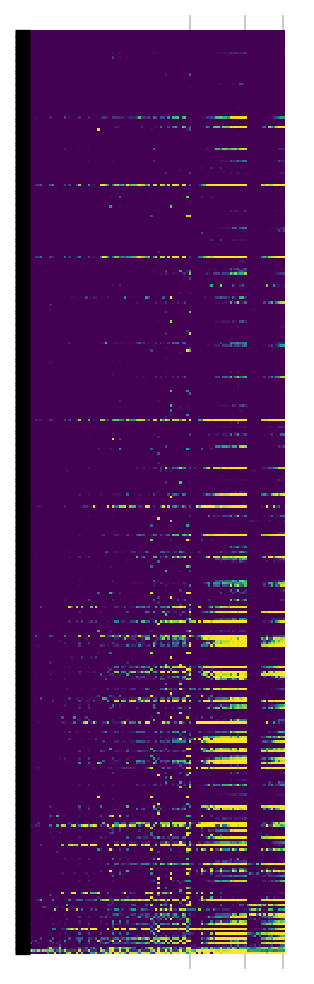

In [10]:
# Uncomment for interactive plot:
# %matplotlib widget

%matplotlib inline

_mols_order_by = 'embedding_cluster_top_descriptor' # embedding_cluster_hdbscan # code_cluster_hdbscan # broadness
_gene_order_by = 'broadness' # family # family_broadness # broadness

bla = df_predict_unstack # .applymap(lambda x: x>0.5)
tmp = df_mols_joint[df_mols_joint['embedding_cluster_hdbscan'].isin([47,38,76])]

_, _, _ = plot_combinatorial_code(_mols_order_by, _gene_order_by, bla, 
                            tmp, df_OR, odor_print_treshold = 100, 
                            transpose = True, cmap = None, discard_unclustered = True, 
                            ticks_broadness_threshold = 1.0)
# _, _, _ = plot_combinatorial_code(_mols_order_by, _gene_order_by, df_predict_unstack, 
#                             df_mols_joint, df_OR, odor_print_treshold = 10, 
#                             transpose = True, cmap = None, discard_unclustered = True, 
#                             ticks_broadness_threshold = 0.1)
# plt.savefig(f'./saved_figures/CC_pyrfume_single_model_Full.png',bbox_inches='tight',pad_inches = 0)
plt.savefig(f'./saved_figures/CC_pyrfume_single_model_tmp2.png',bbox_inches='tight',pad_inches = 0)
plt.show()

## 1 - 2 Per Group

In [11]:
gene_order = df_OR.sort_values('broadness', ascending=False).index
_df = df_mols_joint.copy()
_df = _df[_df['embedding_cluster_hdbscan'] >= 0]
_temp=pd.DataFrame()
_temp['100%'] = _df.groupby('embedding_cluster_hdbscan').apply(get_quantile_per_odor_group, q = 1,)
_temp['90%'] = _df.groupby('embedding_cluster_hdbscan').apply(get_quantile_per_odor_group, q = 0.9,)
_temp['75%'] = _df.groupby('embedding_cluster_hdbscan').apply(get_quantile_per_odor_group, q = 0.75,)
_temp['50%'] = _df.groupby('embedding_cluster_hdbscan').apply(get_quantile_per_odor_group, q = 0.5,)

if not os.path.exists('./saved_figures/CC_pyrfume_single'):
    os.mkdir('./saved_figures/CC_pyrfume_single')

for clus in df_mols_joint.embedding_cluster_hdbscan.unique():
    if clus >= 0: # Discarded unclustered molecules
        cluster = clus
        mat_cluster = df_predict_unstack.loc[df_mols_joint[df_mols_joint.embedding_cluster_hdbscan == cluster].sort_values('broadness', ascending=False).index, gene_order]
        q50  = _temp.loc[cluster, '50%']
        q75  = _temp.loc[cluster, '75%']
        q90  = _temp.loc[cluster, '90%']
        q100 = _temp.loc[cluster, '100%']
        top_descriptors = embedding_cluster_top_descriptor_mapping[cluster]
        print(f'{str(clus).ljust(3)} : {top_descriptors.ljust(27)} : Q(a)({0.5, 0.75, 0.9, 1.0}) = {q50},{q75},{q90},{q100}'.format(clus, top_descriptors))
        
        fig = plt.figure(figsize = (15, 10))
        ax = fig.add_subplot(111)
        ax.matshow(mat_cluster)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'CC_pyrfume_single_model_Cluster_{cluster}_{top_descriptors}_{date.today()}', fontsize = 10)
        fig.savefig(f'./saved_figures/CC_pyrfume_single/Cluster_{cluster}_{date.today()}.png',bbox_inches='tight',pad_inches = 0)
        # plt.show()
        plt.close()

9   : waxy_fatty_oily             : Q(a)((0.5, 0.75, 0.9, 1.0)) = 1.0,3.0,4.0,10.0
85  : fruity_green_apple          : Q(a)((0.5, 0.75, 0.9, 1.0)) = 4.0,6.125,8.0,15.0
143 : fresh_sweet_                : Q(a)((0.5, 0.75, 0.9, 1.0)) = 9.5,29.25,34.2,38.5
204 : floral_woody_violet         : Q(a)((0.5, 0.75, 0.9, 1.0)) = 17.75,38.0,57.75,132.0
124 : fruity_sweet_green          : Q(a)((0.5, 0.75, 0.9, 1.0)) = 5.75,8.0,13.600000000000001,18.5
22  : sulfurous_meaty_onion       : Q(a)((0.5, 0.75, 0.9, 1.0)) = 34.0,61.0,108.00000000000001,191.0
186 : green_aldehydic_leafy       : Q(a)((0.5, 0.75, 0.9, 1.0)) = 28.0,33.0,36.900000000000006,56.0
5   : onion_garlic_sulfurous      : Q(a)((0.5, 0.75, 0.9, 1.0)) = 112.0,125.5,147.0,177.0
165 : fruity_sweet_oily           : Q(a)((0.5, 0.75, 0.9, 1.0)) = 16.0,17.0,22.000000000000004,45.0
30  : fruity_sulfurous_tropical   : Q(a)((0.5, 0.75, 0.9, 1.0)) = 32.0,46.0,48.900000000000006,66.5
23  : sweet_phenolic_nutty        : Q(a)((0.5, 0.75, 0.9, 1.0)) = 4